<a href="https://colab.research.google.com/github/tdbartolo/tdbartolo-rep/blob/main/PNL_transformer_dataset_restaurante_v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# instalando dependências
! pip install transformers[torch] datasets evaluate scikit-learn matplotlib #pip install dataset instala biblioteca do hugging face

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 71.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 52.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 35.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 117.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 84.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 20.2 MB/s eta 0:00:00


In [2]:
# carregando dados do HF
from datasets import load_dataset
#from sklearn.model_selection import train_test_split

url_test = "https://raw.githubusercontent.com/tdbartolo/tdbartolo-rep/main/test.csv"
url_train = "https://raw.githubusercontent.com/tdbartolo/tdbartolo-rep/main/train.csv"

dataset = load_dataset('csv', data_files={'train': url_train, 'test': url_test}, column_names=['text', 'label', 'Recommends'], skiprows=[0])

dataset = dataset.class_encode_column(column="label") # precisa pro trainer saber qual a coluna precisa aprender a predizer

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-84e047cd53280ad2/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

Stringifying the column:   0%|          | 0/13276 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/13276 [00:00<?, ? examples/s]

Stringifying the column:   0%|          | 0/3321 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/3321 [00:00<?, ? examples/s]

In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'Recommends'],
        num_rows: 13276
    })
    test: Dataset({
        features: ['text', 'label', 'Recommends'],
        num_rows: 3321
    })
})

In [4]:
dataset["train"] = dataset["train"].remove_columns("Recommends")
dataset["test"] = dataset["test"].remove_columns("Recommends")

In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 13276
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 3321
    })
})

In [6]:
import pandas as pd
from datasets import Dataset, DatasetDict

# Converter o dataset para um DataFrame pandas
df_train = dataset["train"].to_pandas()
df_test = dataset["test"].to_pandas()

# Remover as linhas com valores vazios ou None
df_train = df_train.dropna()
df_test = df_test.dropna()

df_train['label'] = df_train['label'].astype('int64')
df_test['label'] = df_test['label'].astype('int64')

df_train.loc[:, "text"] = df_train["text"].str.encode("ascii", "ignore").str.decode("utf-8")
df_test.loc[:, "text"] = df_test["text"].str.encode("ascii", "ignore").str.decode("utf-8")

# Converter o DataFrame de volta para o formato de Dataset
dataset["train"] = Dataset.from_pandas(df_train)
dataset["test"] = Dataset.from_pandas(df_test)

In [8]:
#verifica quantos labels únicos temos
set(dataset["train"] ["label"])
#dataset["train"]

{0, 1, 2, 3, 4}

In [ ]:
dataset["train"] = dataset["train"].remove_columns("__index_level_0__")
dataset["test"] = dataset["test"].remove_columns("__index_level_0__")

In [9]:
#mostra a quantidade de linhas do dataset no treino e  no teste
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 11802
    })
    test: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 2876
    })
})

In [10]:
# gerando datasets menores para treino, validação e teste (para poupar tempo)
small_train_dataset = dataset["train"].shuffle(seed=42).select(range(1000)) # pega de 0 a 999 para o treino
small_dev_dataset = dataset["train"].shuffle(seed=42).select(range(1000,1500)) # pega os dados de 1.000 a 1.499 para validação
small_test_dataset = dataset["test"].shuffle(seed=42).select(range(500)) #pega 500 do teste

In [12]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# carregando modelo BERT pré-treinado e o tokenizer do modelo pré-treinado

model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=5)
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initi

In [13]:
#chama a função tokenized e aplica em cada linha do texto
#método map passa uma função em todo o dataset
#o toquenizador criou input_ids', 'token_type_ids', 'attention_mask'

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_small_train_dataset = small_train_dataset.map(tokenize_function, batched=True)
tokenized_small_dev_dataset = small_dev_dataset.map(tokenize_function, batched=True)
tokenized_small_test_dataset = small_test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [14]:
tokenized_small_train_dataset

Dataset({
    features: ['text', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1000
})

In [15]:
#visualização do dataset
import pandas as pd

#small_train_labels = small_train_dataset["Review"]
#small_train_texts = small_train_dataset["Review Text"]

# Criar DataFrames para os conjuntos menores de dados
#small_train_df = pd.DataFrame({'Review': small_train_labels, 'Review Text': small_train_texts})
small_train_df = pd.DataFrame(tokenized_small_train_dataset)

small_train_df.head(10)

,text,label,__index_level_0__,input_ids,token_type_ids,attention_mask
0,Chicken chap and luchi... Awsm taste...with an...,4,9152,"[101, 18770, 22572, 11478, 1105, 181, 16643, 1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,One of my favourite..I just loved the decorati...,4,8051,"[101, 1448, 1104, 1139, 9122, 119, 119, 146, 1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,"Undoubtedly,one of the best place for pizza,pa...",4,8008,"[101, 12118, 2572, 10354, 1906, 1193, 117, 114...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,Taste of the foods were phenomenal the steak w...,4,6915,"[101, 27589, 1104, 1103, 11785, 1127, 14343, 1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,Hidden camera in girls washroom. Everyone boyc...,0,10076,"[101, 19595, 4504, 1107, 2636, 10124, 6077, 11...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
5,", , ? , , ...",1,8867,"[101, 117, 117, 136, 117, 117, 117, 119, 119, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, ..."
6,"Average,, not good at all..quantity and qualit...",2,12260,"[101, 18098, 117, 117, 1136, 1363, 1120, 1155,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
7,It's wallah and delicious... Keep up this fabu...,3,13028,"[101, 1135, 112, 188, 2095, 3354, 1105, 13108,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
8,osmmmm place & also osmmm food I loved it ...,4,11430,"[101, 184, 6602, 6262, 1306, 1282, 111, 1145, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
9,"Classy & delicious food menu , elegant space t...",4,6179,"[101, 3699, 1183, 111, 13108, 2094, 13171, 117...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [ ]:
#ver o dado toquenizado
#tokenized_small_train_dataset [0]


In [16]:
from transformers import Trainer, TrainingArguments
import numpy as np
import evaluate #biblioteca para carregar métrica

metric = evaluate.load("accuracy")

#cria uma função para computar a métrica
def compute_metrics(eval_pred): #eval_pred é o que o modelo previu
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1) #pega o id que tem maior probabilidade
    return metric.compute(predictions=predictions, references=labels) #compara o ID predito com o label esperado

#onde vai salvar o modelo treinado
MODEL_PATH = "modelo_aula_bert_2"

training_args = TrainingArguments(
    output_dir=MODEL_PATH,
    evaluation_strategy="steps", #fazer o evaluation no step de validação a cada 10 steps
    eval_steps=10,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=4, # gradient_accumulation_steps* per_device_eval_batch_size=batch
    max_steps=200,  #por quantos steps eu quero treinar o modelo
    learning_rate=3e-5,
    logging_strategy="steps", #a cada 10 steps vai printar
    logging_steps=10,
    save_steps=50, #salvar check point a cada 50 steps
    load_best_model_at_end=True, #pega o melhor dos que salvou
    metric_for_best_model="accuracy",
    greater_is_better=True, #se for maior é bom pq acurácia é medida de acerto
    save_total_limit=2, #quantos checkpoints vai salvar
    disable_tqdm=False #aparece a barrinha carregando
)
#entra com o modelo definido acima, os argumentos e os datasets, o trainer espera a função que computa a métrica
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_small_train_dataset,
    eval_dataset=tokenized_small_dev_dataset,
    compute_metrics=compute_metrics,
)

# Nova seção

In [17]:
#treina o modelo
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
10,1.321900,1.216282,0.574000
20,1.068500,1.170673,0.574000
30,1.178000,1.022632,0.574000
40,0.987600,0.925085,0.684000
50,0.825600,0.874913,0.698000
60,0.802300,0.849548,0.716000
70,0.687800,0.828346,0.706000
80,0.685800,0.831322,0.686000
90,0.572700,0.820055,0.684000
100,0.543000,0.821325,0.686000


TrainOutput(global_step=200, training_loss=0.6320878446102143, metrics={'train_runtime': 923.8681, 'train_samples_per_second': 6.927, 'train_steps_per_second': 0.216, 'total_flos': 1683956111769600.0, 'train_loss': 0.6320878446102143, 'epoch': 6.4})

In [18]:
#verifica se loss está muito ruidoso (sobe e desce) que o learning rate pode estar muito alto ou o dado estar ruim
import pandas as pd

df_log = pd.DataFrame(trainer.state.log_history)
df_log

,loss,learning_rate,epoch,step,eval_loss,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,1.3219,0.000028,0.32,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,0.32,10,1.216282,0.574,15.5146,32.228,4.061,NaN,NaN,NaN,NaN,NaN
2,1.0685,0.000027,0.64,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,0.64,20,1.170673,0.574,16.5637,30.186,3.803,NaN,NaN,NaN,NaN,NaN
4,1.1780,0.000025,0.96,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,0.96,30,1.022632,0.574,16.7398,29.869,3.763,NaN,NaN,NaN,NaN,NaN
6,0.9876,0.000024,1.28,40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,1.28,40,0.925085,0.684,16.7580,29.837,3.759,NaN,NaN,NaN,NaN,NaN
8,0.8256,0.000023,1.60,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,1.60,50,0.874913,0.698,16.7057,29.930,3.771,NaN,NaN,NaN,NaN,NaN


<Axes: >

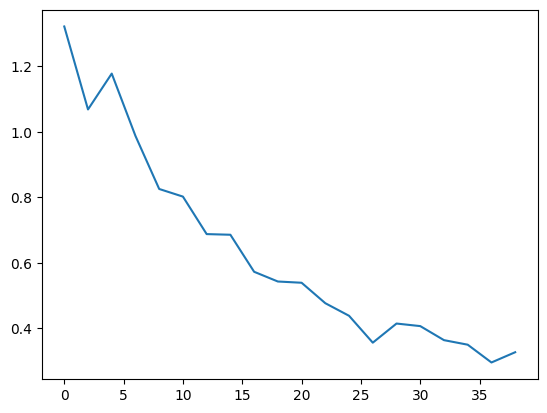

In [19]:
df_log["loss"].dropna().plot()

<Axes: >

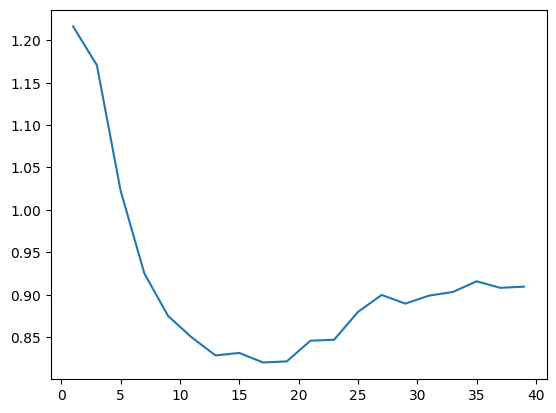

In [20]:
#se o eval_loss desce muito e depois sobe é sinal de overfitting
df_log["eval_loss"].dropna().plot()

<Axes: >

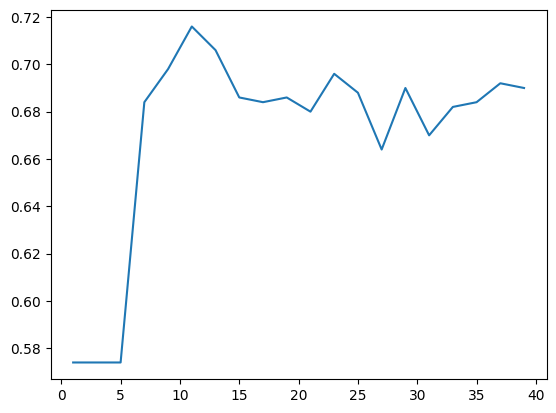

In [21]:
df_log["eval_accuracy"].dropna().plot()

In [22]:
#roda o evaluate no teste para ver como o modelo vai se comportar
trainer.evaluate(tokenized_small_test_dataset)

{'eval_loss': 0.8931140899658203,
 'eval_accuracy': 0.676,
 'eval_runtime': 16.7782,
 'eval_samples_per_second': 29.801,
 'eval_steps_per_second': 3.755,
 'epoch': 6.4}

In [23]:
#salva o modelo e o tokenizador
trainer.save_model(MODEL_PATH)
tokenizer.save_pretrained(MODEL_PATH)

('modelo_aula_bert_2/tokenizer_config.json',
 'modelo_aula_bert_2/special_tokens_map.json',
 'modelo_aula_bert_2/vocab.txt',
 'modelo_aula_bert_2/added_tokens.json',
 'modelo_aula_bert_2/tokenizer.json')

In [26]:
import torch.nn.functional as F
import torch
#carrega o nosso modelo que salvamos no ambiente de execução do colab/podemos salvar no computador para não ter que treinar novamente
model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH)
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
text = "This is a really bad restaurant"
#text = "This is a really excellent restaurant, but the drink was hot"
#text = "This is a really excellent restaurant"
encoded_input = tokenizer(text, return_tensors="pt")
output = model(**encoded_input) #carrega os parametros criados pelo tokenizador - input_ids, token_type_ids, attention_mask
probs = F.softmax(output.logits, dim=1) #carrega o softmax para colocar os valores entre 0 e 1 para facilitar a visualização
pred = torch.argmax(probs, dim=1)
print(probs)
pred

tensor([[0.4037, 0.1549, 0.1898, 0.1353, 0.1164]], grad_fn=<SoftmaxBackward0>)


tensor([0])

In [27]:
encoded_input

{'input_ids': tensor([[ 101, 1188, 1110,  170, 1541, 2213, 4382,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]])}